**tl;dr: We use [dask](http://dask.pydata.org/en/latest/) to accelerate parameter searches over machine learning pipelines by naming consistently.**

*This work builds on work done with [Andreas Mueller](http://amueller.github.io/), [Olivier Grisel](http://ogrisel.com/), with suggestions by [Gael Varoquaux](http://gael-varoquaux.info/)*

*Disclaimer: this blogpost discusses experimental and buggy code.*

Outline
-------

Computational costs of machine learning applications are multiplied by the
following:

1.  Pipelines of several transformations
2.  Parameter searches over each component of those pipelines

Even though the execution of particular components may only take a few seconds,
the multiplication of parameter searches over many components may easily blow
up full solution time to several minutes or hours.

Fortunately individual computations for a single parameter set can be done
in an embarassingly parallel manner.  Scikit learn already supports parallel
execution in this manner with
[joblib](https://pythonhosted.org/joblib/parallel.html).

However, if we're clever we can identify and reuse identical computations
shared across pipelines with different parameter sets.  In many cases this can
lead to very striking performance increases that are completely separate from 
the gains of parallel computing

This post details a trivial copy of sklearn's `Pipeline` object built with dask 
and how, by paying careful attention to naming tasks, we're able to drastically
speedup parameter search computations, even without parallelism.

Code is available here: https://github.com/mrocklin/dasklearn

Problem Definition
------------------

This section poses a scikit-learn problem that we will accelerate in future sections.  If you are unfamiliar with scikit-learn you can safely skip details.

#### Consider the following pipeline



In [1]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectFdr
from sklearn.svm import LinearSVC

pipeline = Pipeline([("count", CountVectorizer()),
                     ("select_fdr", SelectFdr()),
                     ("svm", LinearSVC())])

For a set of documents we do the following:

1.  Extract features (words) with a count vectorizer
2.  Select an important subset of features/words
3.  Perform a linear support vector classification



#### Collect newsgroups data

We grab some documents from newgroups to play with.

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    'alt.atheism',
    'talk.religion.misc',
]

data_train = fetch_20newsgroups(subset='train', categories=categories)
data_test = fetch_20newsgroups(subset='test', categories=categories)

#### Train/test split:

We use the train/test splits found in the downloaded data


In [3]:
X_train, y_train = data_train.data, data_train.target
X_test, y_test = data_test.data, data_test.target

#### Fit, predict, score

We finally fit our pipeline on the training data, predict on the testing data,
and then score how well our pipeline performs.


In [4]:
%%time
pipeline.fit(X_train, y_train).score(X_test, y_test)

CPU times: user 581 ms, sys: 0 ns, total: 581 ms
Wall time: 581 ms


0.77017543859649118

77% classification accuracy after less than a second of computation time.  Great. 

#### Parameter Searches

We can acheive better scores by tuning the parameters of each of the components of
the pipeline.  The default parameters provided by scikit-learn are quite sane but 
datasets vary and parameter tuning helps.

So we're going to choose a few parameters in the second and third parts of our pipeline and consider all possible combinations.

*Disclaimer: to make this problem more explicit we avoid sklearn's `GridSearch` 
object and just use a for loop.  Please don't do this in practice.*


In [5]:
import numpy as np
parameters = [{'select_fdr__alpha': alpha, 'svm__C': C}
              for alpha in [0.05, 0.01, 0.1, 0.2]
              for C in np.logspace(-3, 2, 6)]

In [6]:
%%time
scores = [pipeline.set_params(**params)
                  .fit(X_train, y_train)
                  .score(X_test, y_test)
          for params in parameters]

CPU times: user 11.9 s, sys: 0 ns, total: 11.9 s
Wall time: 11.9 s


In [7]:
{'best-score': max(scores), 
 'best-parameters': parameters[np.argmax(scores)]}

{'best-parameters': {'select_fdr__alpha': 0.2, 'svm__C': 0.01},
 'best-score': 0.79649122807017547}

So modest parameter searching yield a bit of an improvement at a 20x cost increase.  For problems of real size this change can grow significantly larger.

Accelerate with dasklearn.Pipeline
----------------------------------

We've built a tiny dask Pipeline object to mimic sklearn's.

It looks the same but has a couple of important differences

1.  It does not support mutation, you must reassign after `.fit` and `.set_params` calls.  E.g.

          sklearn:            pipeline.fit(X, y)
        dasklearn: pipeline = pipeline.fit(X, y)
        
    In this post we only use method chaining, so this won't come up.
2.  Results are lazy dask objects, we'll need to do a final `compute` step get the full results.

In [8]:
# from sklearn.pipeline import Pipeline
from dasklearn.pipeline import Pipeline

pipeline = Pipeline([("count", CountVectorizer()),
                     ("select_fdr", SelectFdr()),
                     ("svm", LinearSVC())])

When used for a single parameter set it's a silly use of dask.
The computation isn't very parallelizable.

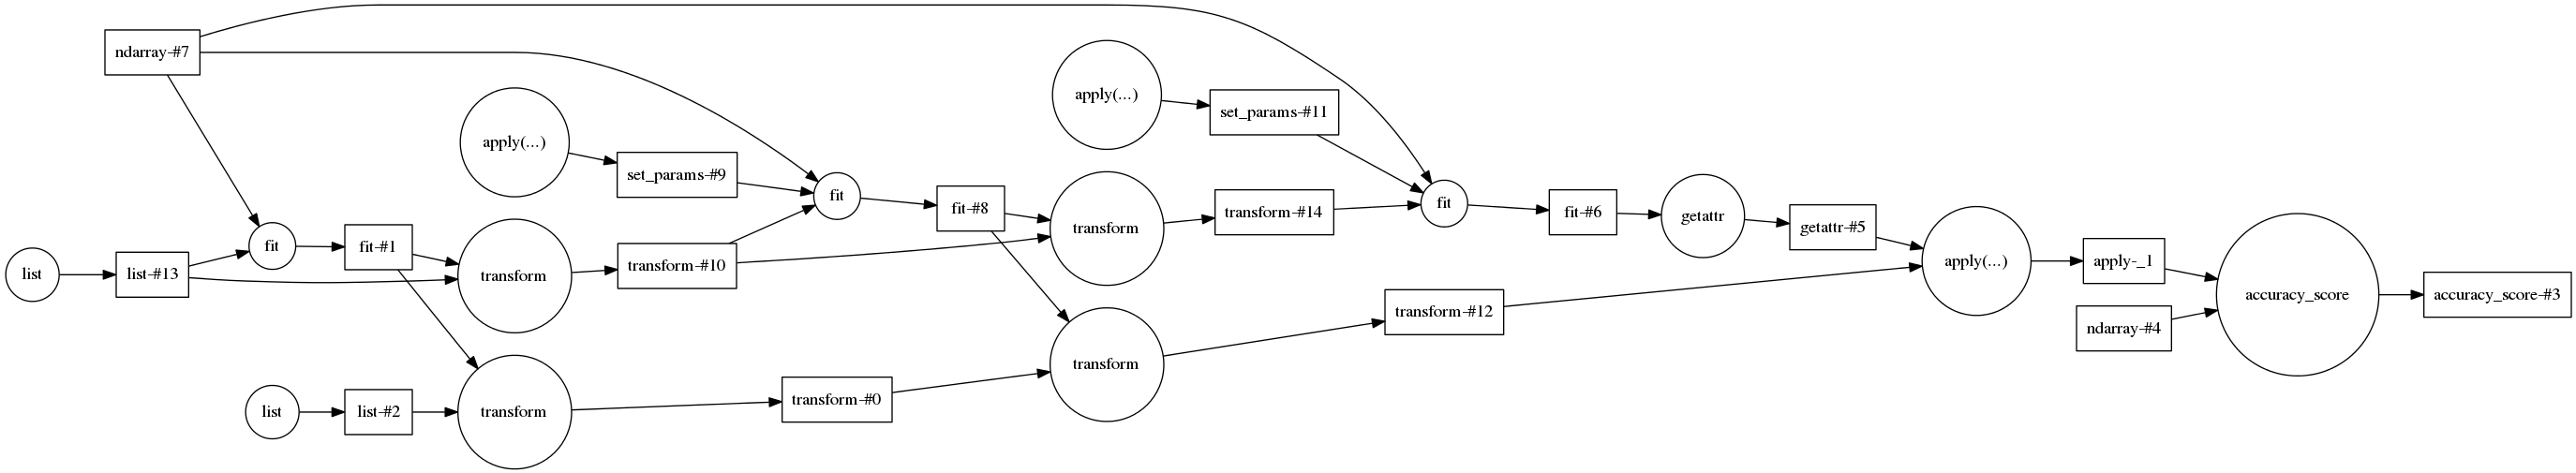

In [9]:
from dask.base import visualize
params1 = parameters[1]
score1 = (pipeline.set_params(**params1)
                  .fit(X_train, y_train)
                  .score(X_test, y_test))

visualize(score1, rankdir='LR')

However, when we combine two of these objects something wonderful happens, almost nothing changes.

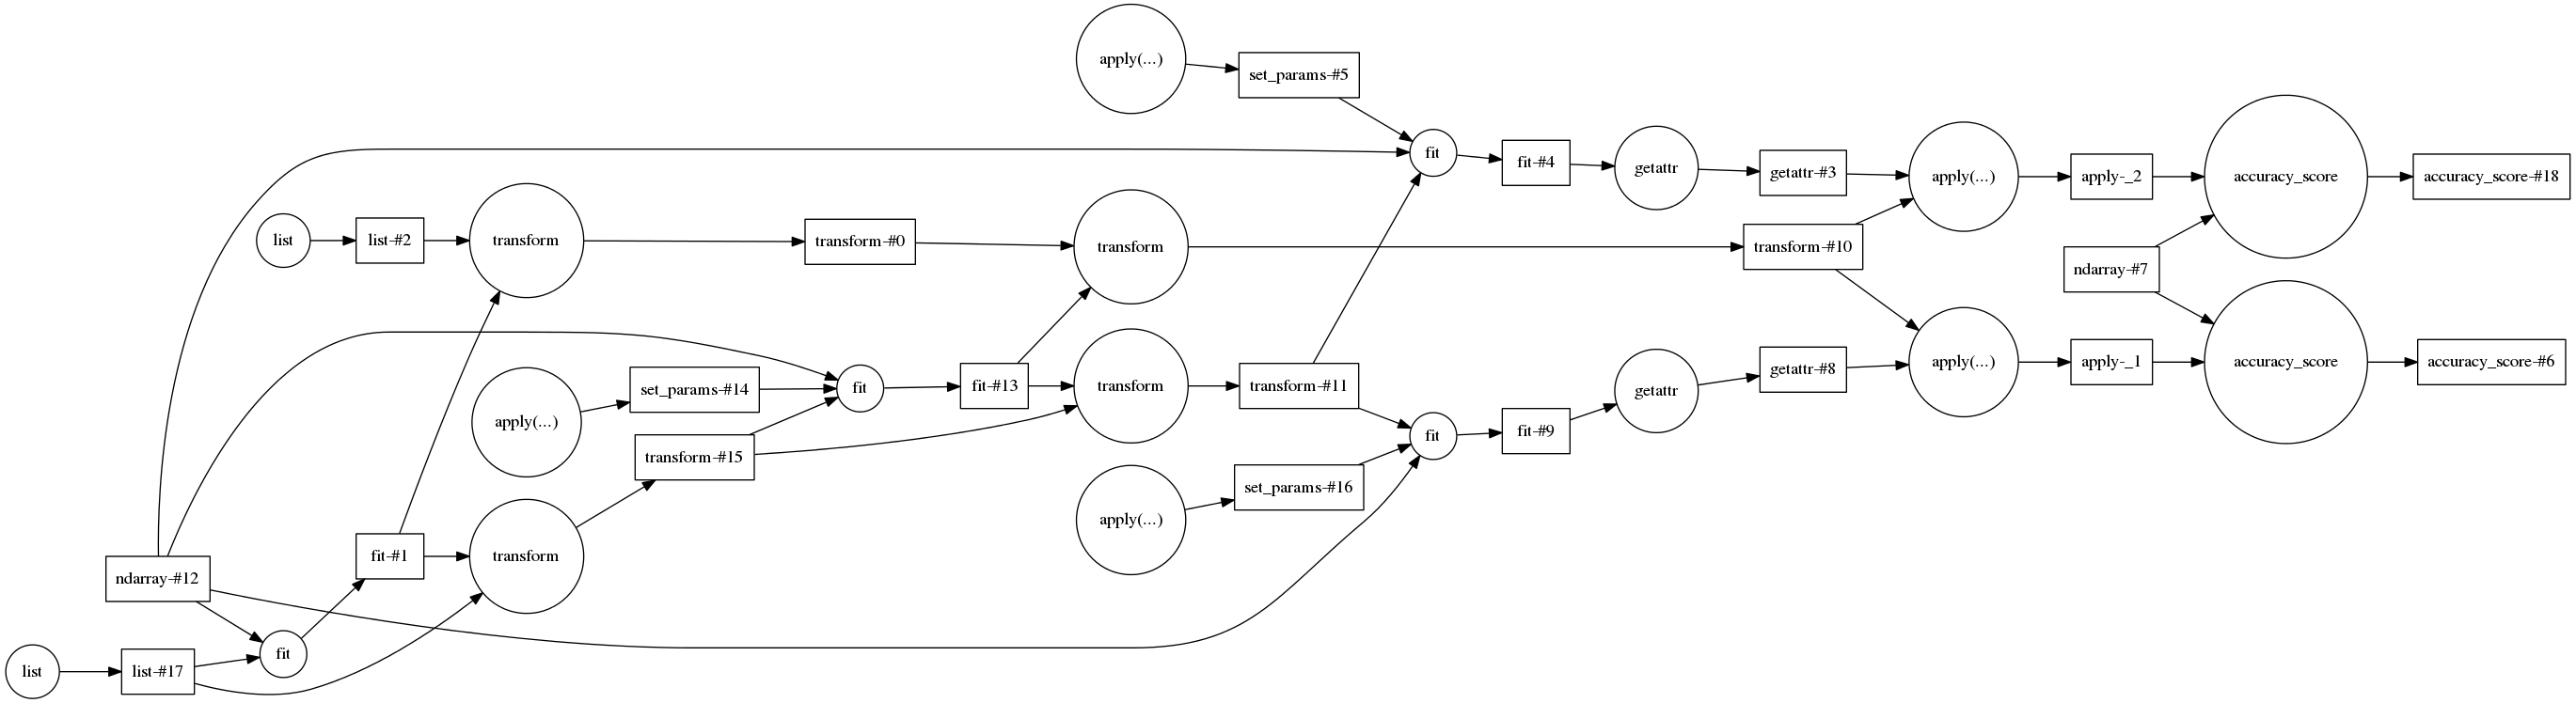

In [10]:
params2 = parameters[2]
score2 = (pipeline.set_params(**params2)
                  .fit(X_train, y_train)
                  .score(X_test, y_test))

visualize(score1, score2, rankdir='LR')

Almost nothing changes because our parameter sets are actually pretty similar. There are no parameters in the first component of the pipeline, `CountVectorizer`, and the second component, `SelectFDR`, has the same value for both parameter sets.  We only need to recompute the last component, the `LinearSVC`.  

We accelerate our computation by identifying and avoiding redundant computations that are shared across multiple runs.

In [11]:
parameters[1], parameters[2]

({'select_fdr__alpha': 0.05, 'svm__C': 0.01},
 {'select_fdr__alpha': 0.05, 'svm__C': 0.10000000000000001})

Full Computation
-------------------

OK, we've talked enough, lets run the entire computation.

In [12]:
from dask.imperative import compute
from dask.async import get_sync  # no parallelism

In [13]:
%%time
scores = [pipeline.set_params(**params)
                  .fit(X_train, y_train)
                  .score(X_test, y_test)
           for params in parameters]

result = compute(scores, get=get_sync)[0]

CPU times: user 1.87 s, sys: 16 ms, total: 1.88 s
Wall time: 1.88 s


In [14]:
{'best-score': max(result), 
 'best-parameters': parameters[np.argmax(result)]}

{'best-parameters': {'select_fdr__alpha': 0.2, 'svm__C': 0.01},
 'best-score': 0.79649122807017547}

A modest 3x increase here rather than 20x.  

A large part of this increase is still in dask hashing overhead, which we can remove by pre-specifying our arrays as dask values.

In [15]:
%%time
from dask.imperative import value
X_train, y_train, X_test, y_test = map(value, [X_train, y_train, X_test, y_test])

scores = [pipeline.set_params(**params)
                  .fit(X_train, y_train)
                  .score(X_test, y_test)
           for params in parameters]

result = compute(scores, get=get_sync)

CPU times: user 1.24 s, sys: 0 ns, total: 1.24 s
Wall time: 1.24 s


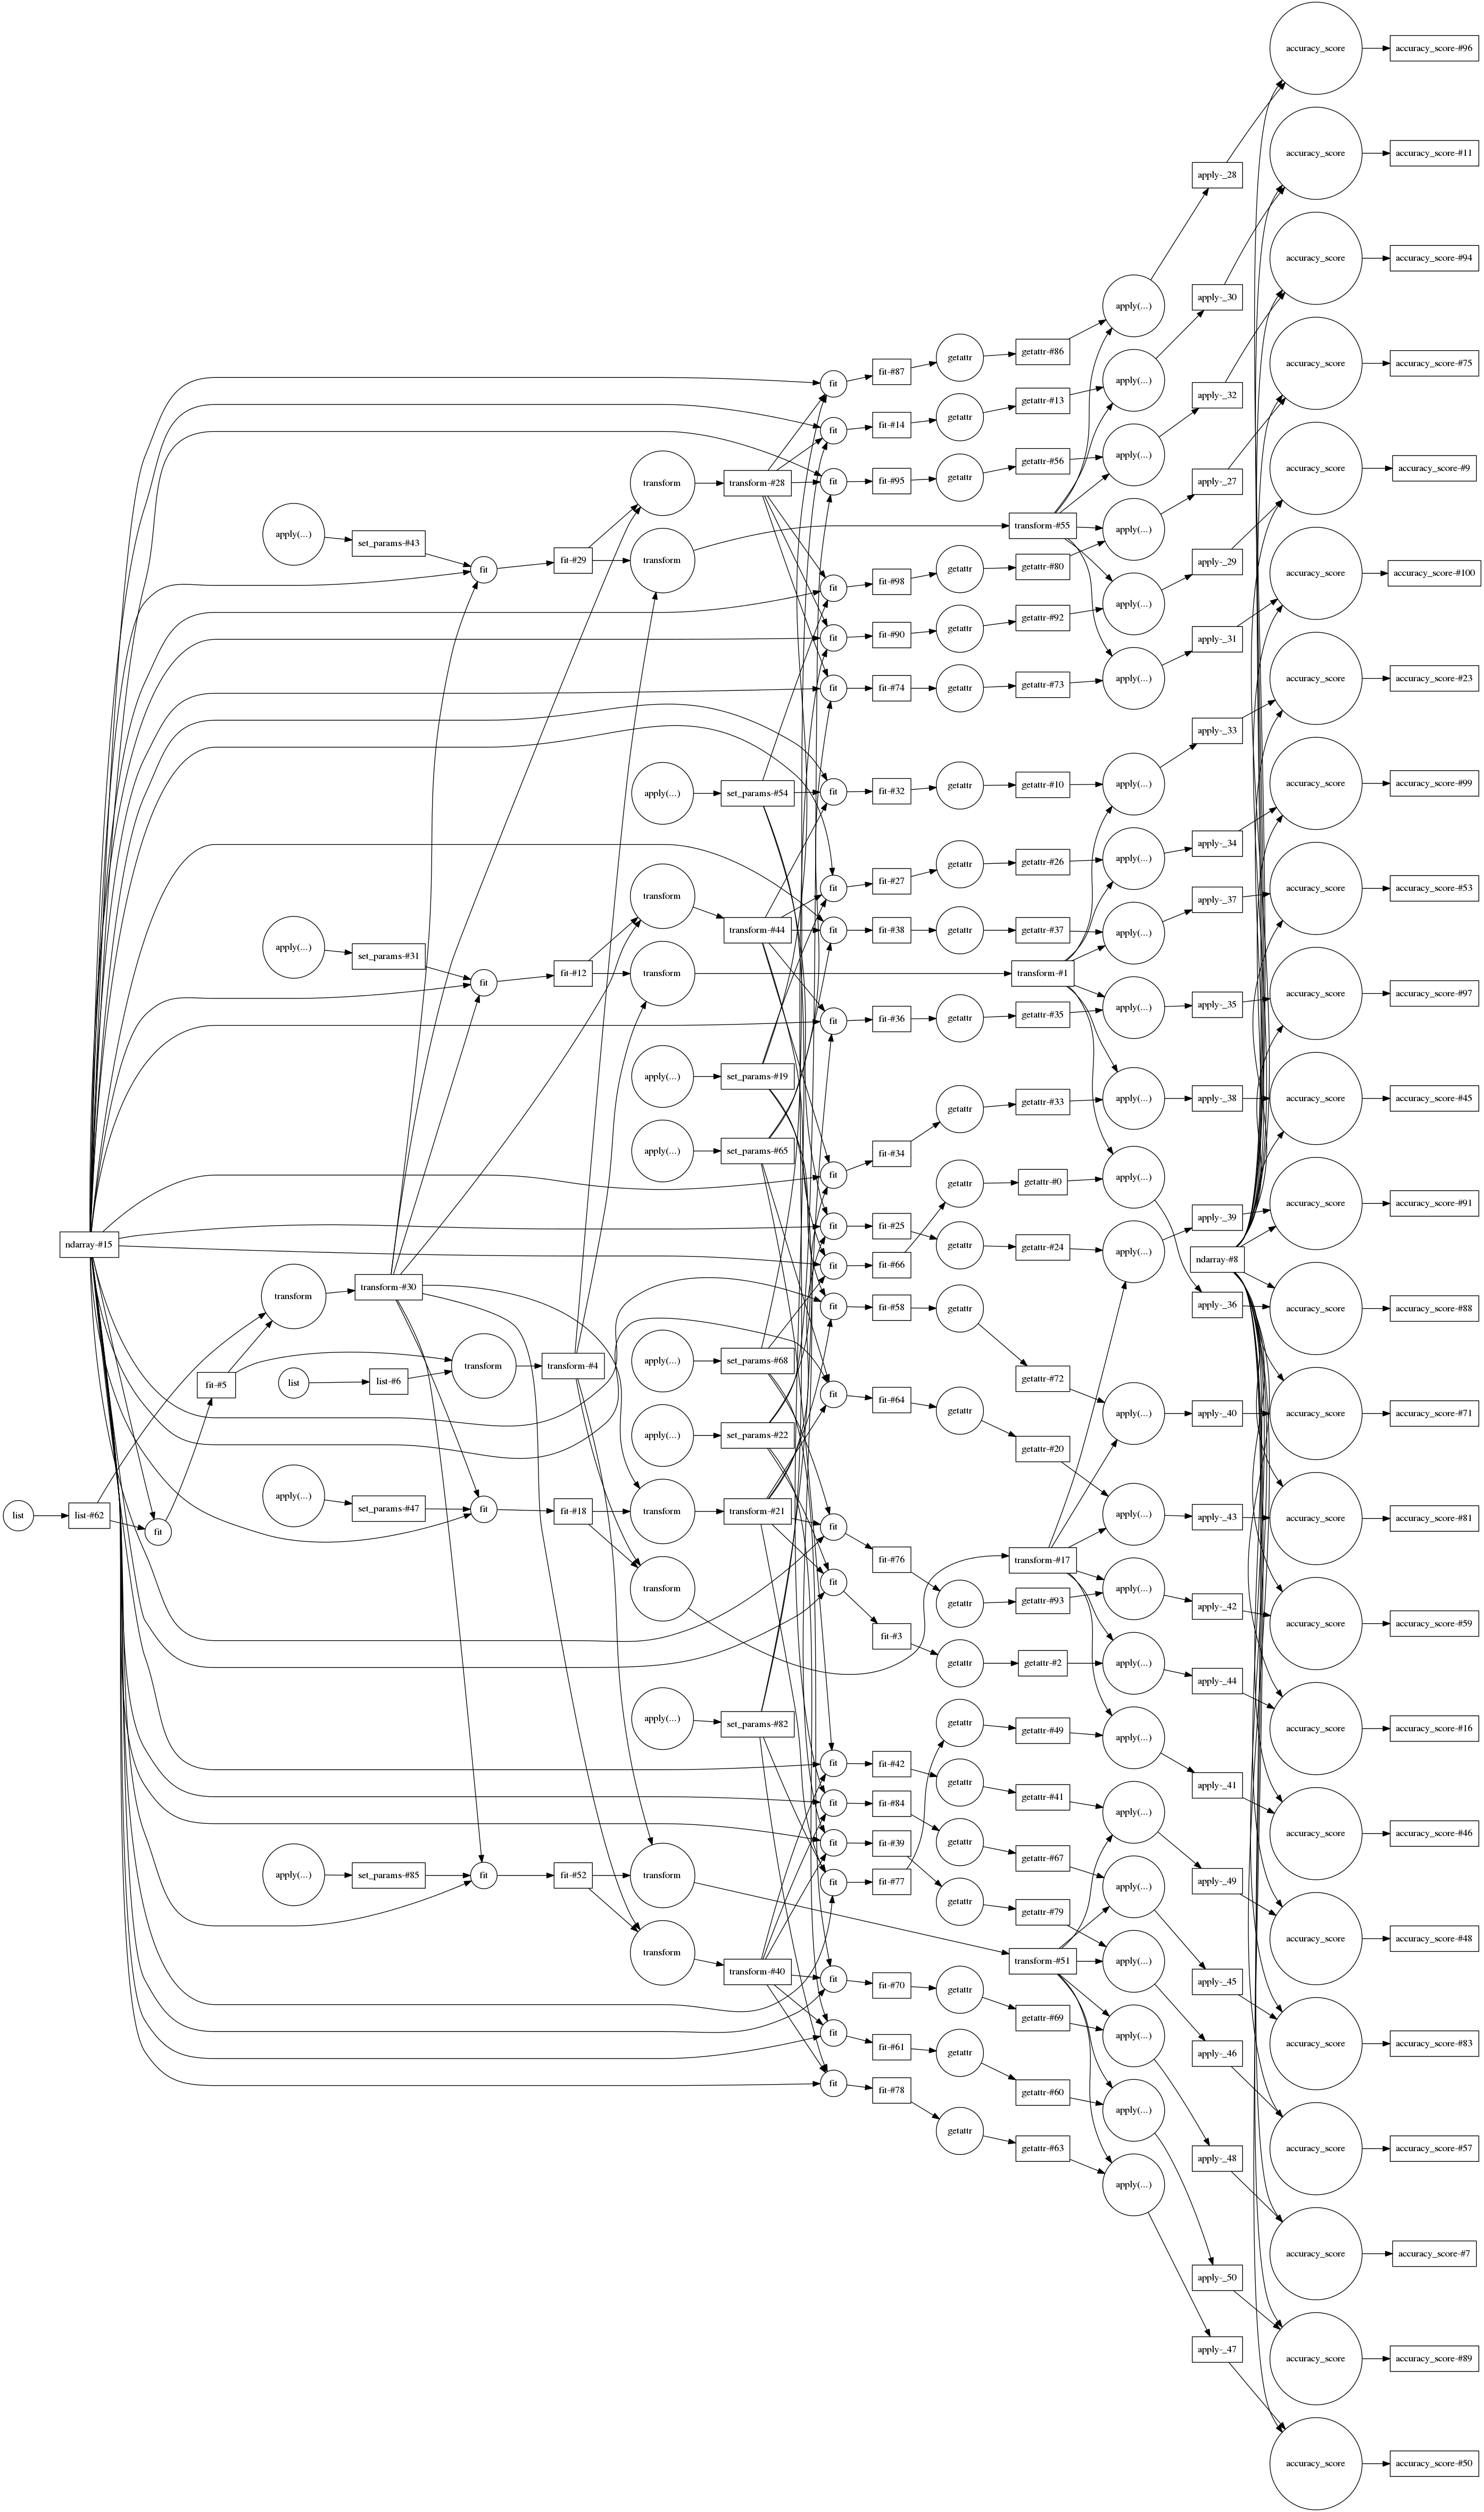

In [16]:
visualize(*scores, rankdir='LR')

Discussion
------------

There are some tradeoffs here.  

1.  We compute less, but our computation is no longer embarrassingly parallel.  

    Parallel programming projects that expose a parallel `map` are no longer sufficient.  
    We need a full-fledged task scheduler like `dask`.
2.  In order to identify equivalent components from different pipelines we have to be very careful about naming all of our tasks consistently.  In particular, we hash all of the inputs carefully and propogate those inputs to future computations in order to make something like a *content-addressable-computation*.  This is similar to how `git` or other content-addressable-storage systems work.  This naming process is useful, but does add a 500MB/s cost to our computation (this is usually marginal.)

Future Work
-------------

The `dasklearn` project is the result of a sprint between sklearn developers and myself.  It's unpolished.  Notably it includes a rough `GridSearchCV` implementation.  I hope that an intrepid machine learning contributor comes around and takes this on.

For what other algorithms could this approach be extended?

The [Pipeline implementation](https://github.com/mrocklin/dasklearn/blob/master/dasklearn/pipeline.py) is a pretty clean use of [dask.imperative](http://dask.pydata.org/en/latest/imperative.html).  My hope is that other people who are more in touch with the machine learning community's needs are able to build off of this.